## **0. Загрузка необходимых библиотек.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime

from datetime import datetime
from scipy.stats import normaltest
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## **0.5. Структура базы данных.**

**Данные о клиенте и таксопарке:**

**id** — уникальный идентификатор поездки;

**vendor_id** — уникальный идентификатор поставщика услуг (таксопарка), связанного с записью поездки.

**Временные характеристики:**

**pickup_datetime** — дата и время, когда был включён счётчик поездки;

**dropoff_datetime** — дата и время, когда счётчик был отключён.

**Географическая информация:**

**pickup_longitude** — долгота, на которой был включён счётчик;

**pickup_latitude** — широта, на которой был включён счётчик;

**dropoff_longitude** — долгота, на которой счётчик был отключён;

**dropoff_latitude** — широта, на которой счётчик был отключён.

**Прочие признаки:**

**passenger_count** — количество пассажиров в транспортном средстве (введённое водителем значение);

**store_and_fwd_flag** — флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику (Y — хранить и пересылать, N — не хранить и не пересылать поездку).

**Целевой признак:**

**trip_duration** — продолжительность поездки в секундах.

## **1. Загрузка данных.**

In [2]:
taxi_data = pd.read_csv("content/train.csv")
print('Data shape: {}'.format(taxi_data.shape))

Data shape: (1458644, 11)


## **2. Предварительная работа с данными.**

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')

In [4]:
start = taxi_data['pickup_datetime'].dt.date.min()
stop = taxi_data['dropoff_datetime'].dt.date.max()
print(f'Временные рамки находятся между {start} и {stop}')

Временные рамки находятся между 2016-01-01 и 2016-07-01


In [5]:
taxi_data.isna().sum() #К нашему счастью, пропусков в данных нет.

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
taxi_data['vendor_id'].unique() #Сколько уникальных таксопарков присутствует в данных?

array([2, 1], dtype=int64)

In [7]:
taxi_data['passenger_count'].max() #Каково максимальное количество пассажиров?

9

In [8]:
int(taxi_data['trip_duration'].mean()), int(taxi_data['trip_duration'].median()), int(taxi_data['trip_duration'].min()), int(taxi_data['trip_duration'].max())

(959, 662, 1, 3526282)

Примечание. На основе полученной статистической информации о целевом признаке trip_duration мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как усечённое среднее, логарифмическое среднее или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в неё тремя столбцами:

pickup_date — дата включения счётчика/начала поездки (без времени);

pickup_hour — час включения счётчика;

pickup_day_of_week — день недели, в который был включён счётчик.

In [9]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

In [10]:
taxi_data = add_datetime_features(taxi_data)
taxi_data.groupby('pickup_date')['pickup_datetime'].count().mean()

8014.527472527472

In [11]:
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday


In [12]:
holiday_data = pd.read_csv("content/holiday_data.csv",sep =';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d')
holiday_data

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


In [13]:
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   day      14 non-null     object        
 1   date     14 non-null     datetime64[ns]
 2   holiday  14 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 464.0+ bytes


In [14]:
def add_holiday_features(taxi_df, holiday_df):
    taxi_df['pickup_date'] = pd.to_datetime(taxi_df['pickup_date'], format='%Y-%m-%d') #Преобразуем в формат Date
    holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%Y-%m-%d') #Преобразуем в формат Date
    merged_df = taxi_df.join(holiday_df.set_index('date'), on='pickup_date', how='left') #Объединим DataFrames
    merged_df = merged_df.rename(columns={"holiday": "pickup_holiday"}) # Переименуем столбец
    merged_df = merged_df.drop(['day'], axis=1) # Удалим столбец DAY
    merged_df["pickup_holiday"] = merged_df["pickup_holiday"].fillna(0) # Произведём замену NAN на 0 в столбце pickup_holiday
    merged_df["pickup_holiday"].loc[merged_df["pickup_holiday"] != 0] = 1

    return merged_df
taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17944\3201036679.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["pickup_holiday"].loc[merged_df["pickup_holiday"] != 0] = 1


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0


In [15]:
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0


In [16]:
int(taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median())

585

In [17]:
osrm_data_train = pd.read_csv("content/osrm_data_train.csv")
osrm_data_train.shape

(1458643, 12)

In [18]:
osrm_data_train.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [19]:
def add_osrm_features(taxi_df, osrm_df):
    geo_df = taxi_df.join(osrm_df.set_index('id')[['total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left') #Объединим DataFrames
    return geo_df
taxi_data = add_osrm_features(taxi_data, osrm_data_train)
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0,2234.6,311.7,8.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0,7638.0,589.6,11.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0,9871.5,642.9,10.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0


In [20]:
int(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())

372

In [21]:
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,Friday,0,2234.6,311.7,8.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,Sunday,0,7638.0,589.6,11.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,Friday,0,9871.5,642.9,10.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0


In [22]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус Земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсайна
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновлённую таблицу с добавленными в неё двумя столбцами:

haversine_distance — расстояние Хаверсина между точкой, в которой был включён счетчик, и точкой, в которой счётчик был выключен;

direction — направление движения из точки, в которой был включён счётчик, в точку, в которой счётчик был выключен.
Примените полученную функцию к таблице.

Чему равно медианное расстояние Хаверсина поездок (в километрах)? Ответ округлите до двух знаков после точки-разделителя.

In [23]:
def add_geographical_features(data):
  data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'],data['pickup_longitude'],data['dropoff_latitude'],data['dropoff_longitude'])
  data['direction'] = get_angle_direction(data['pickup_latitude'],data['pickup_longitude'],data['dropoff_latitude'],data['dropoff_longitude'])
  return data
taxi_data = add_geographical_features(taxi_data)
taxi_data['haversine_distance'].median()

2.0937171329263693

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

→ Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации.

Функция должна возвращать обновлённую таблицу с добавленным в неё столбцом geo_cluster (географический кластер, к которому относится поездка).

Сколько поездок содержится в наименьшем по размеру географическом кластере?

In [24]:
def add_cluster_features(taxi_df):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    return taxi_df
taxi_data = add_cluster_features(taxi_data)

In [25]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [26]:
taxi_data['geo_cluster'].value_counts().min()
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,13,Friday,0,2234.6,311.7,8.0,1.225080,-119.059338,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,7,Sunday,0,7638.0,589.6,11.0,6.049836,25.342196,9
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,6,Friday,0,9871.5,642.9,10.0,7.824606,-150.788492,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,2016-01-05,15,Tuesday,0,1628.3,161.6,7.0,1.092564,35.033294,0


In [27]:
weather_data = pd.read_csv("content/weather_data.csv")
weather_data

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782,2017-01-01 21:00:00,5.0,3.3,NaN,0.43,1028.5,-6.7,16.1,ENE,7.4,0.0,0.0,None,Clear,2017-01-01,21
8783,2017-01-01 22:00:00,5.6,3.6,NaN,0.38,1029.3,-7.8,16.1,NE,9.3,0.0,0.0,None,Clear,2017-01-01,22
8784,2017-01-01 23:00:00,5.6,4.0,NaN,0.38,1030.2,-7.8,16.1,NE,7.4,0.0,0.0,None,Clear,2017-01-01,23
8785,2017-01-02 00:00:00,5.0,3.3,NaN,0.41,1030.6,-7.2,16.1,ENE,7.4,0.0,0.0,None,Clear,2017-01-02,0


Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:

таблицу с данными о поездках;

таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:

temperature - температура;

visibility - видимость;

wind speed - средняя скорость ветра;

precip - количество осадков;

events - погодные явления.

In [28]:
def add_weather_features(data, weather):
    weather['time'] = pd.to_datetime(weather['time'])
    weather['date'] = pd.to_datetime(weather['date'])
    weather['hour'] = weather['time'].dt.hour

    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]

    data = data.merge(
        weather[weather_columns],
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'],
        how='left'
    )
    data = data.drop(['date', 'hour'], axis=1)
    return data

In [29]:
taxi_data_wth = add_weather_features(taxi_data, weather_data)
taxi_data_wth

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


In [30]:
taxi_data_wth[taxi_data_wth['events'] == 'Snow'].shape[0]


13126

In [31]:
NaN_s = len(taxi_data_wth)-taxi_data_wth['events'].count() # считаем количество пропусков в столбце
prop_n = NaN_s / len(taxi_data_wth)*100
print(f'пропуски в столбцах с погодными условиями занимают {round(prop_n,2)} %')

пропуски в столбцах с погодными условиями занимают 0.82 %


Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями - temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.

Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.

Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

In [32]:
def fill_null_weather_data(taxi_df):
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    taxi_df[col] = taxi_df[col].fillna(taxi_df.groupby('pickup_date')[col].transform('median'))
    taxi_df['events'] = taxi_df['events'].fillna('None')
    taxi_df['total_distance'] = taxi_df['total_distance'].fillna(taxi_df['total_distance'].median(skipna=True))
    taxi_df['total_travel_time'] = taxi_df['total_travel_time'].fillna(taxi_df['total_travel_time'].median(skipna=True))
    taxi_df['number_of_steps'] = taxi_df['number_of_steps'].fillna(taxi_df['number_of_steps'].median(skipna=True))
    return taxi_df
taxi_fill = fill_null_weather_data(taxi_data_wth)
temp = taxi_fill['temperature'].median()
print(f'медианная температура в столбце temperature равна {temp} градусов')

медианная температура в столбце temperature равна 11.1 градусов


In [33]:
taxi_fill

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,311.7,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,589.6,11.0,6.049836,25.342196,9,7.2,2.8,18.5,8.1,Rain
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,642.9,10.0,7.824606,-150.788492,4,18.3,16.1,0.0,0.0,None
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,161.6,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None


In [34]:
trip_dur = taxi_data_wth[(taxi_data_wth['trip_duration']>86400)]
print(f'количество выбросов по признаку длительности поездки: {trip_dur.shape[0]}')

количество выбросов по признаку длительности поездки: 4


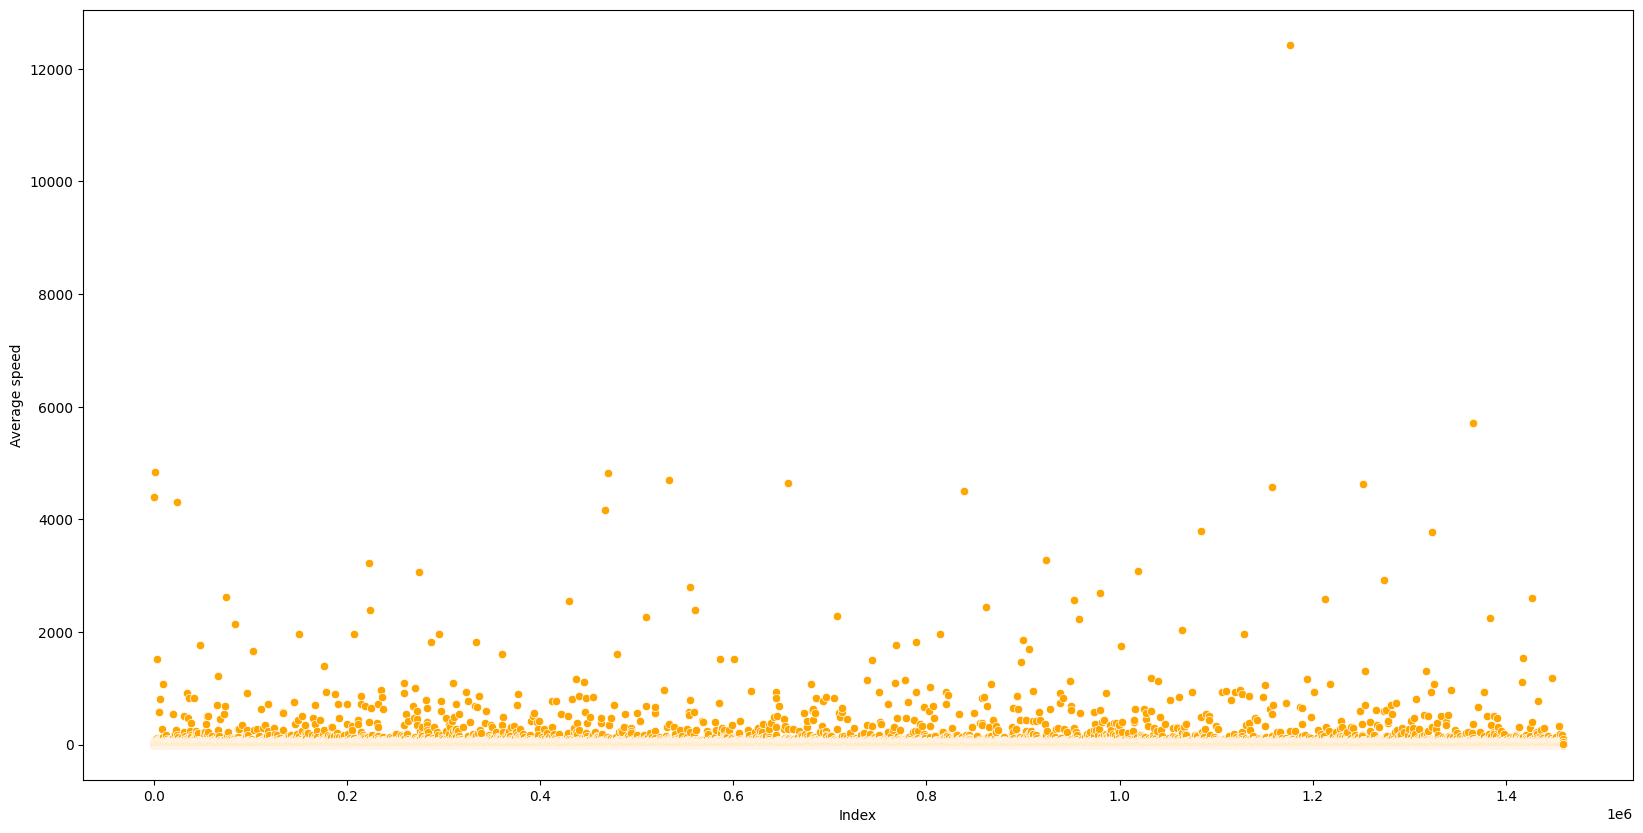

In [38]:
avg_speed = taxi_data_wth['total_distance'] / taxi_data_wth['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(20, 10))
plt.style.use('dark_background')
sns.scatterplot(x=avg_speed.index, color='orange', y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

In [35]:
avg_sp = taxi_data_wth[((taxi_data_wth['total_distance'] / taxi_data_wth['trip_duration'] * 3.6) >=300)]
print(f'количество выбросов по признаку скорости: {avg_sp.shape[0]}')

количество выбросов по признаку скорости: 407


In [36]:
taxi_data = taxi_data_wth.drop(trip_dur.index, axis=0)
taxi_data = taxi_data_wth.drop(avg_sp.index, axis=0)

In [37]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458237 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458237 non-null  object        
 1   vendor_id           1458237 non-null  int64         
 2   pickup_datetime     1458237 non-null  datetime64[ns]
 3   dropoff_datetime    1458237 non-null  datetime64[ns]
 4   passenger_count     1458237 non-null  int64         
 5   pickup_longitude    1458237 non-null  float64       
 6   pickup_latitude     1458237 non-null  float64       
 7   dropoff_longitude   1458237 non-null  float64       
 8   dropoff_latitude    1458237 non-null  float64       
 9   store_and_fwd_flag  1458237 non-null  object        
 10  trip_duration       1458237 non-null  int64         
 11  pickup_date         1458237 non-null  datetime64[ns]
 12  pickup_hour         1458237 non-null  int64         
 13  pickup_day_o

Исследуем сформированный набор данных;
Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
Дополним наш анализ визуализациями, иллюстрирующими исследование.

Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.

Начинаем с целевого признака.
Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе.
В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
trip_duration_log = log(trip_duration + 1), где под символом log подразумевается натуральный логарифм.

In [38]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Задание 3.1.¶
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\2667146434.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(taxi_data['trip_duration_log'], color='orange')


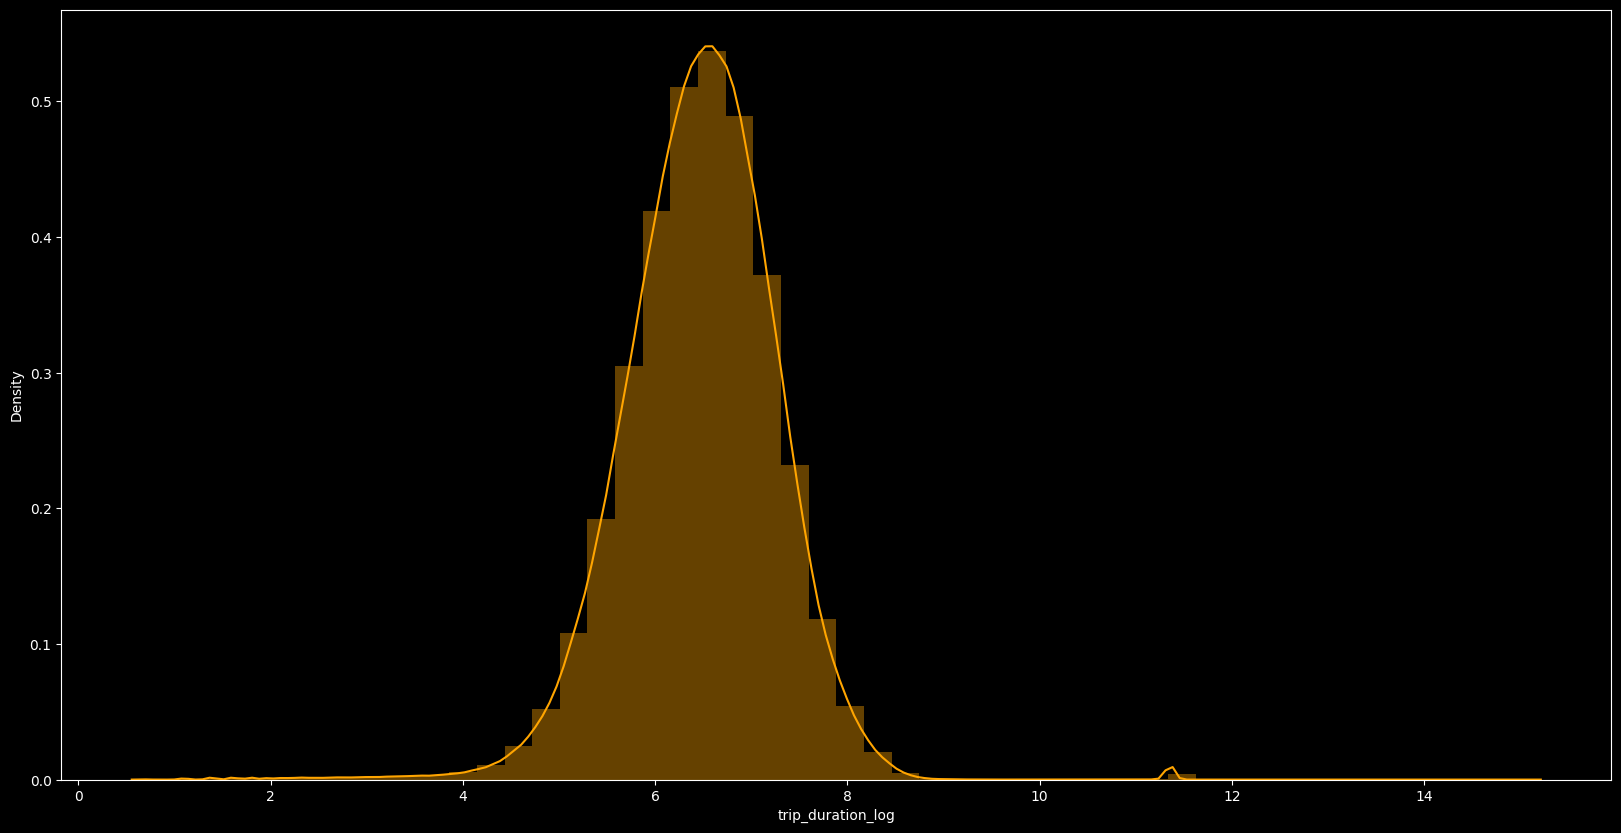

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
sns_plot = sns.distplot(taxi_data['trip_duration_log'], color='orange')
fig = sns_plot.get_figure()

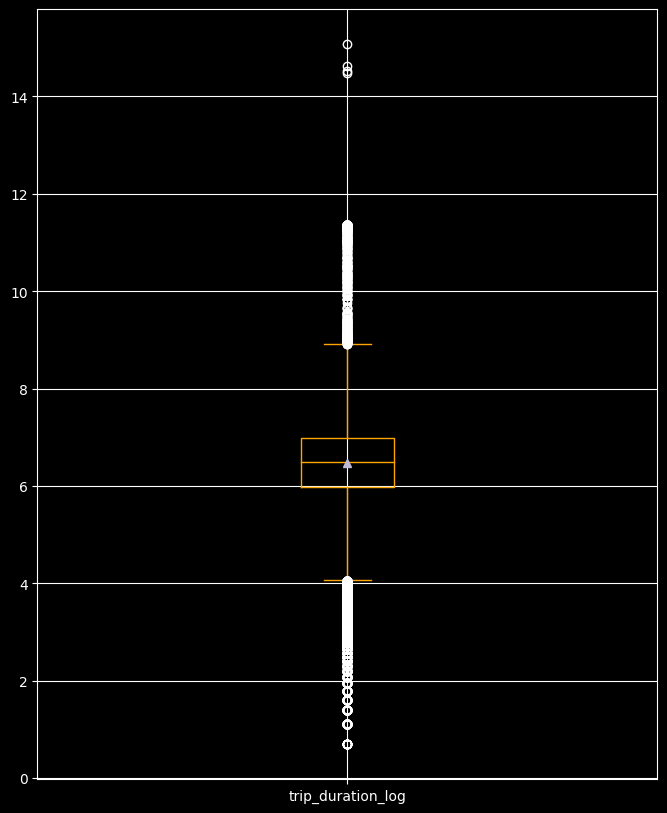

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))
plt.style.use('dark_background')
pd.DataFrame(taxi_data['trip_duration_log']).boxplot(sym='o', whis=1.95, color='orange', showmeans=True)
plt.show()

In [39]:
stat, p = normaltest(taxi_data['trip_duration_log'])
alpha = 0.05

In [40]:
if p < alpha:  # проверка условия
    print("Данные не распределены нормально (мы отвергаем H0)")
else:
    print("Данные распределены нормально")

Данные не распределены нормально (мы отвергаем H0)


Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

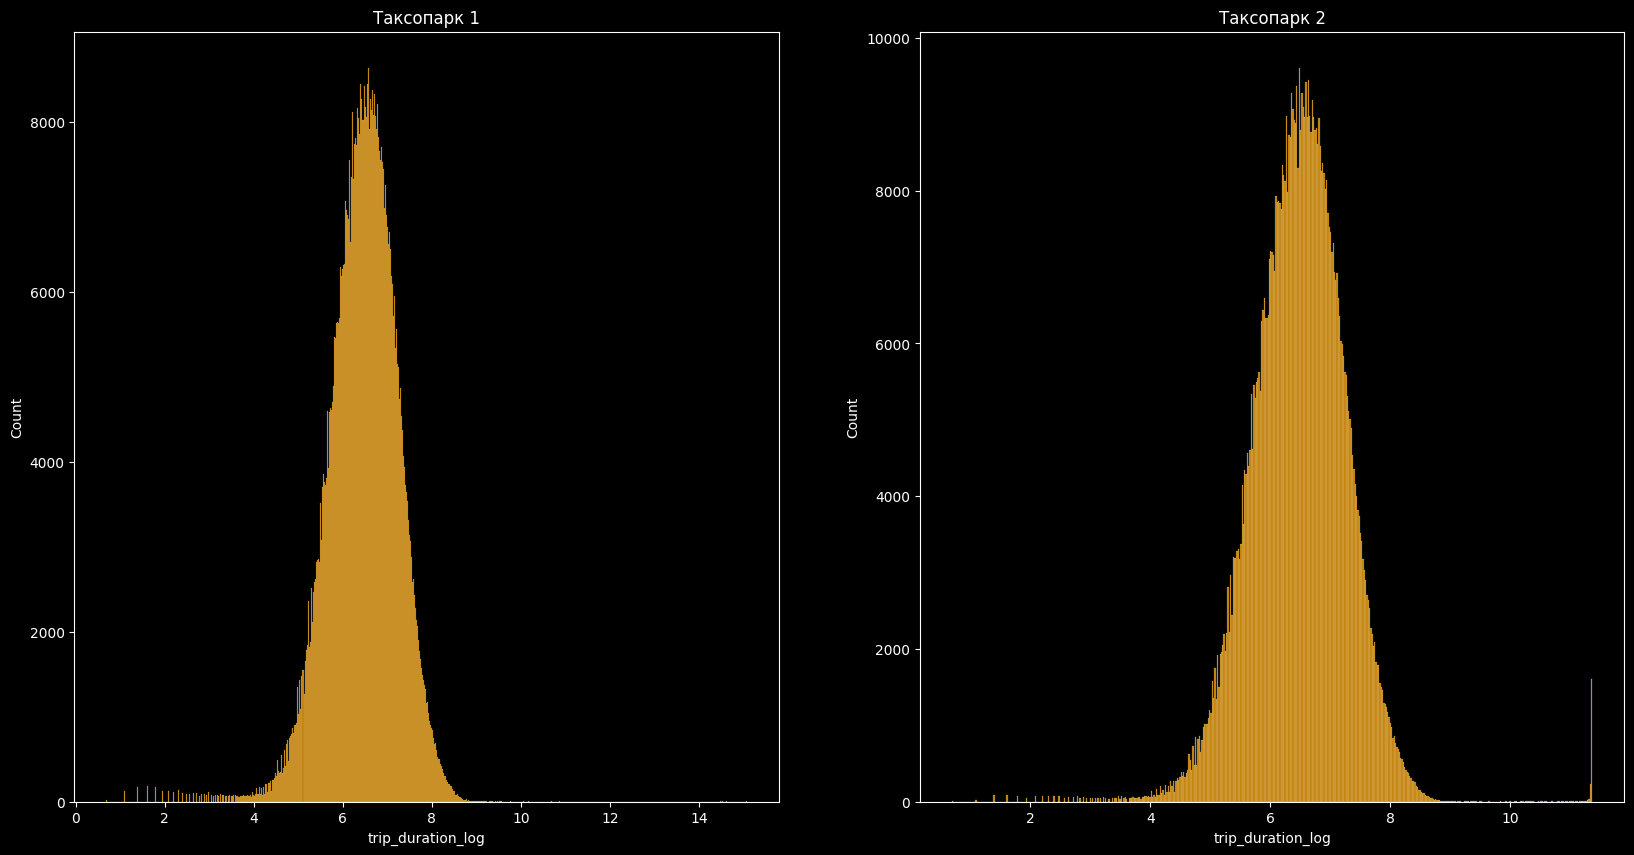

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plt.style.use('dark_background')
histplot = sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log'],color='orange', ax=axes[0]);
histplot.set_title('Таксопарк 1');
histplot = sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log'],color='orange', ax=axes[1]);
histplot.set_title('Таксопарк 2');

Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

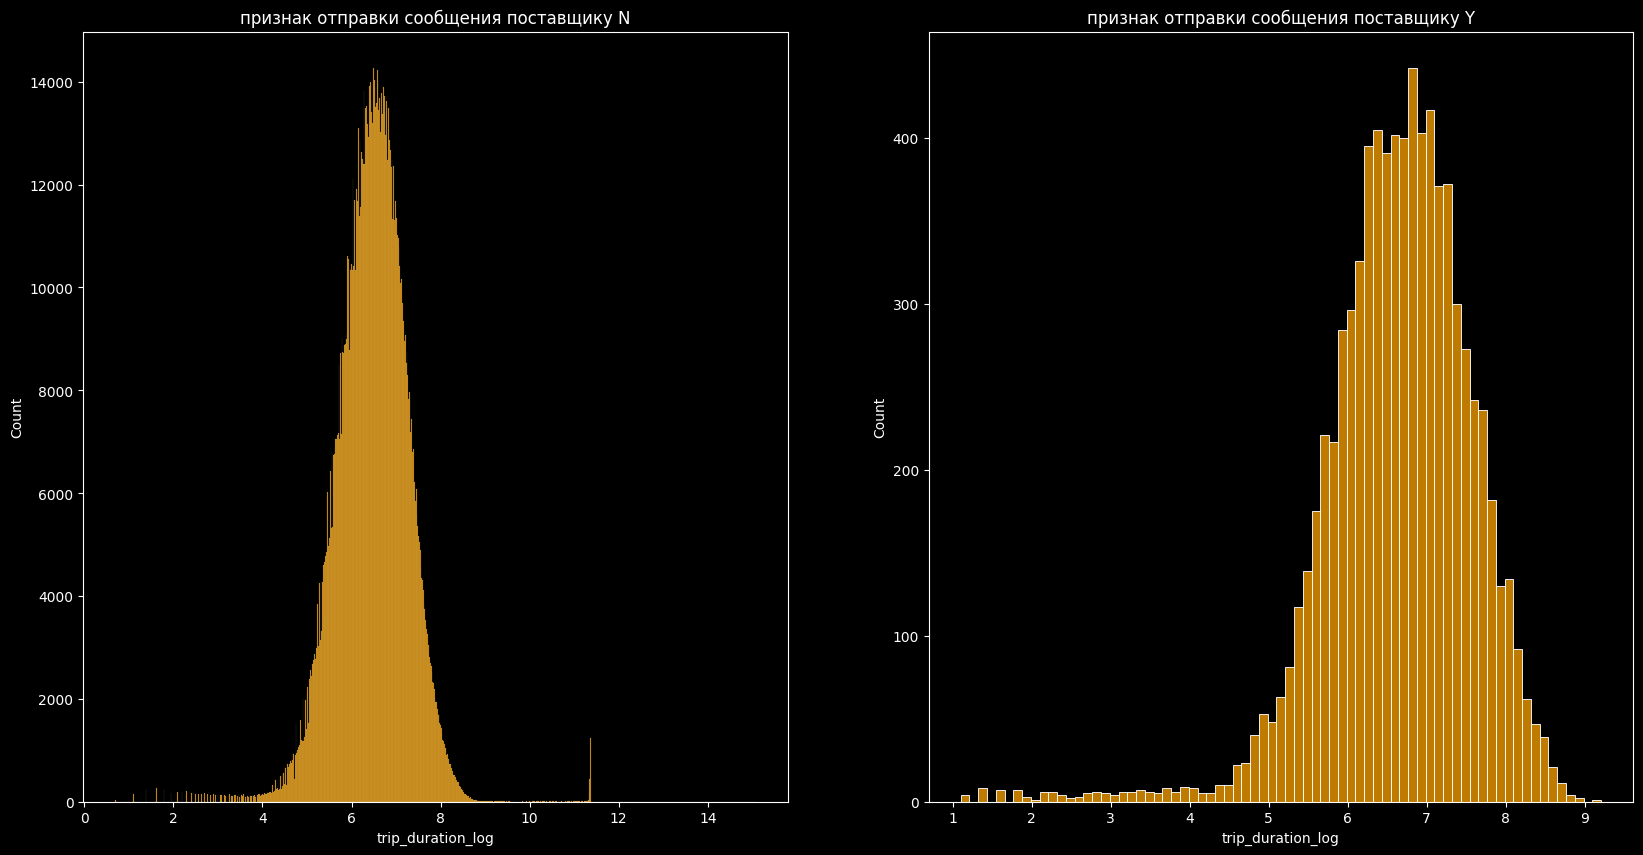

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plt.style.use('dark_background')
histplot = sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'N']['trip_duration_log'],color='orange', ax=axes[0]);
histplot.set_title('признак отправки сообщения поставщику N');
histplot = sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']['trip_duration_log'],color='orange', ax=axes[1]);
histplot.set_title('признак отправки сообщения поставщику Y');

Задание 3.4.
Постройте две визуализации:

Распределение количества поездок в зависимости от часа дня;

Зависимость медианной длительности поездки от часа дня.

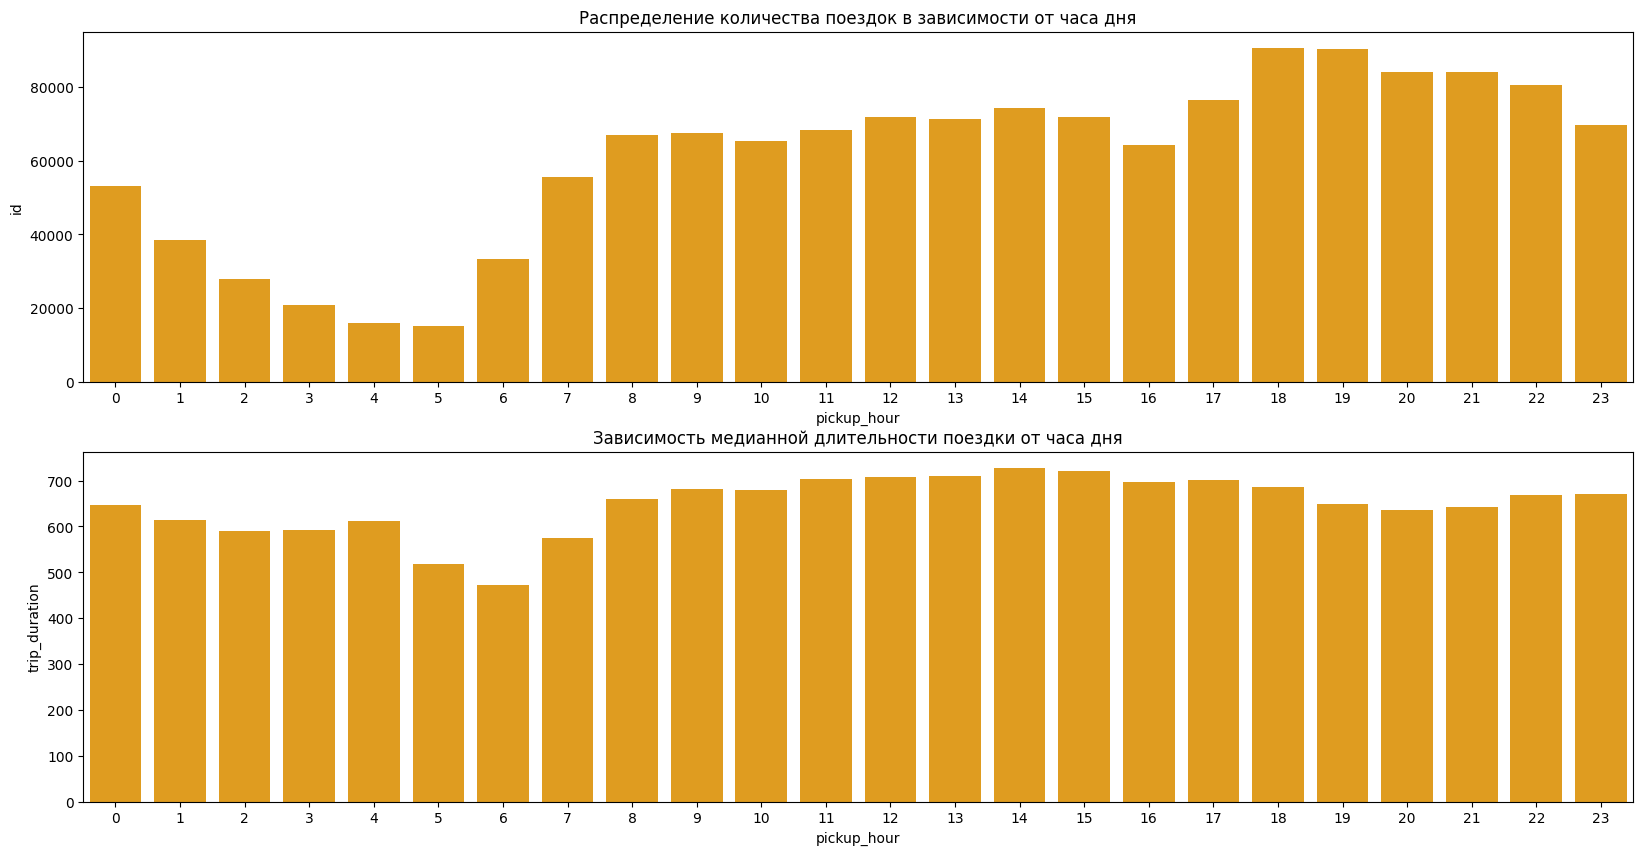

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
#fig = plt.figure(figsize=(15, 7))

data1 = taxi_data.groupby(by='pickup_hour', as_index=False).count();
data2 = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].median();
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='orange',
    ax=axes[0]);
barplot.set_title('Распределение количества поездок в зависимости от часа дня');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от часа дня');
barplot.bar_label(barplot.containers[0]);

Задание 3.5.
Постройте две визуализации:

Распределение количества поездок в зависимости от дня недели;
Зависимость медианной длительности поездки от дня недели.

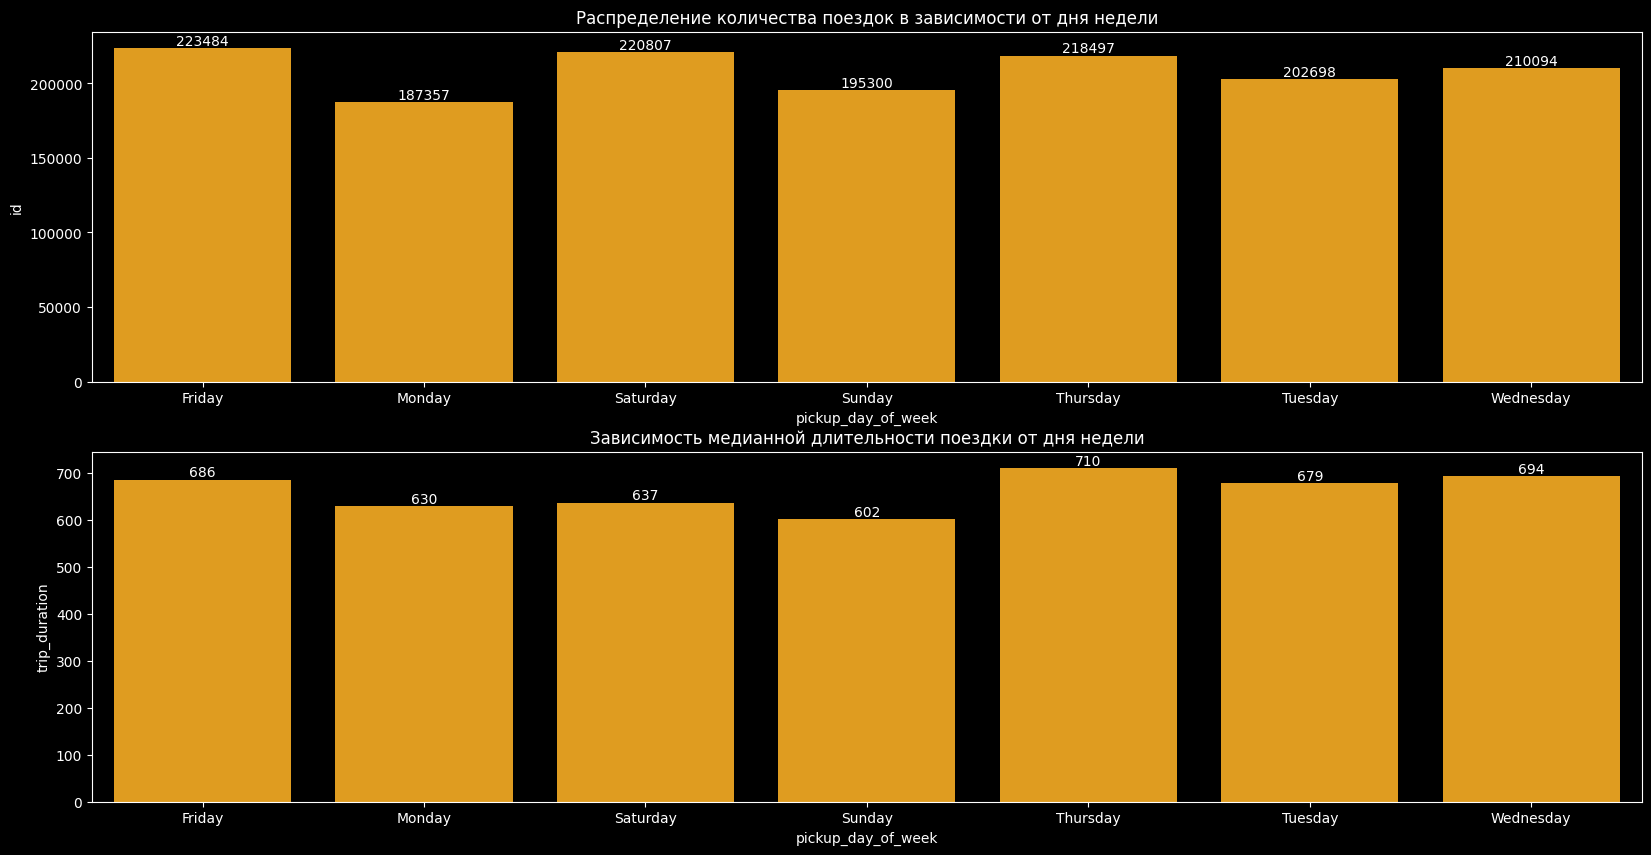

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.style.use('dark_background')
#fig = plt.figure(figsize=(15, 7))
data1 = taxi_data.groupby(by='pickup_day_of_week', as_index=False).count()
data2 = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='orange',
    ax=axes[0])
barplot.set_title('Распределение количества поездок в зависимости от дня недели');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от дня недели');
barplot.bar_label(barplot.containers[0]);

Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [42]:
trip=taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    fill_value=0,
    aggfunc='median'
)
trip

pickup_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
pickup_hour,,,,,,,
0,649.0,598,685.0,675.0,609,591.5,601.0
1,600.0,567,640.0,643.0,564,584.0,553.0
2,572.0,565,610.0,604.5,576,565.0,544.0
3,578.0,600,591.0,608.0,584,568.0,574.0
4,634.0,640,610.0,598.5,595,600.5,616.0
5,532.0,519,631.0,634.0,480,455.0,448.0
6,476.0,462,508.0,554.0,471,461.0,463.0
7,578.0,575,481.0,474.0,599,586.0,593.0
8,689.0,672,489.0,460.0,721,703.0,704.0


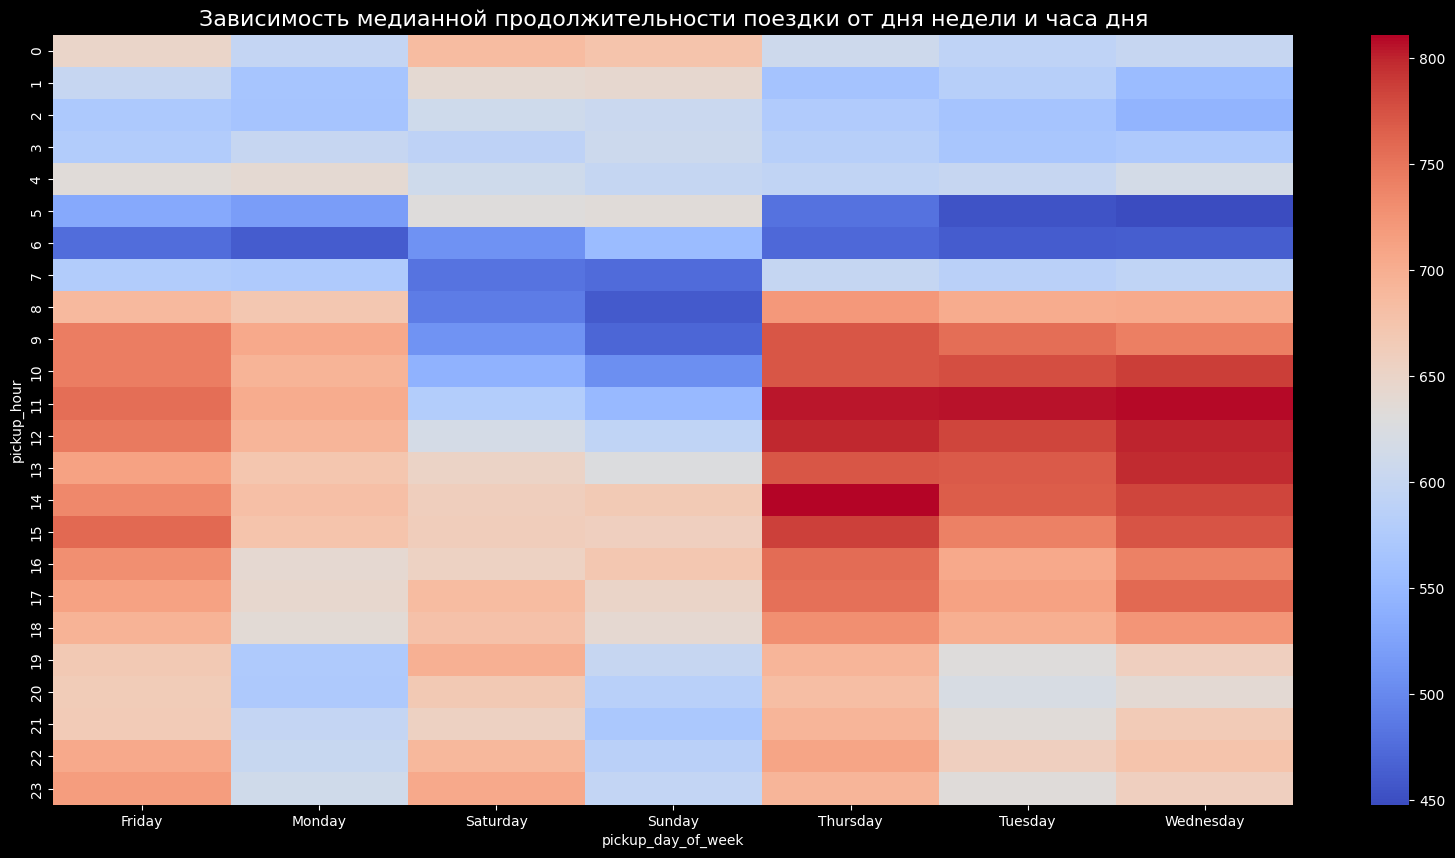

In [51]:
f, ax = plt.subplots(figsize=(20, 10))
plt.style.use('dark_background')
trip_time=sns.heatmap(data=trip,
            cmap="coolwarm");
trip_time.set_title('Зависимость медианной продолжительности поездки от дня недели и часа дня', fontsize=16);

Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):

первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).
Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

Рекомендация: для наглядности уменьшите размер точек на диаграмме рассеяния.

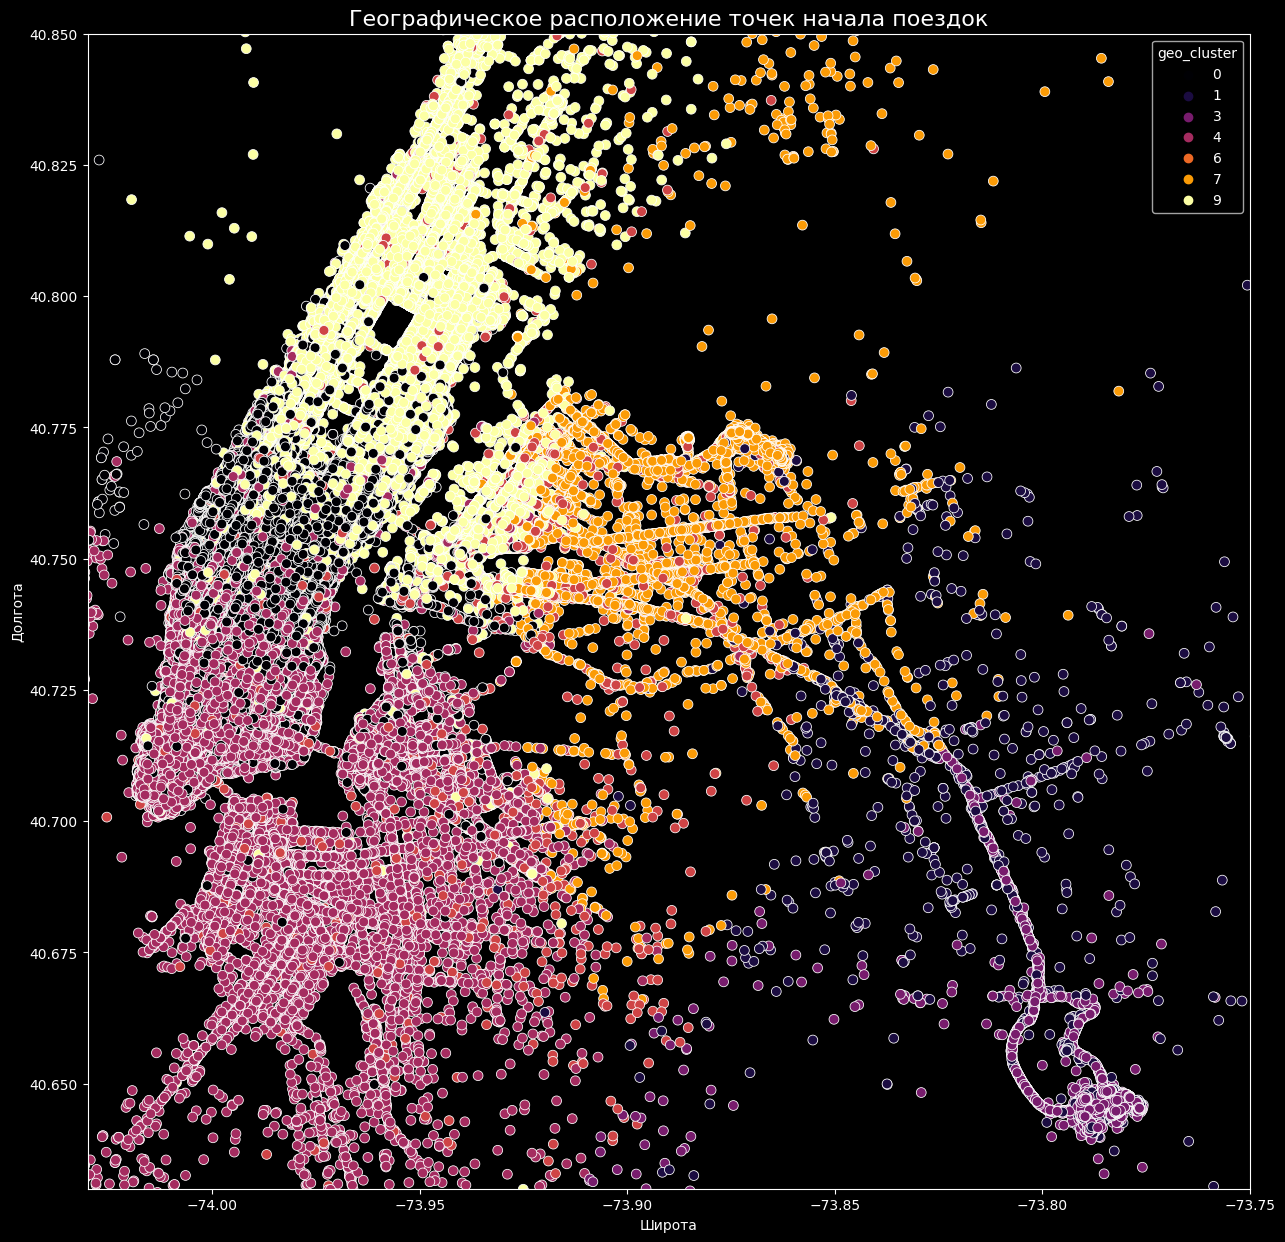

In [45]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot1 = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot1.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot1.set_title('Географическое расположение точек начала поездок', fontsize=16);
scatterplot1.set_xlabel('Широта');
scatterplot1.set_ylabel('Долгота');

NameError: name 'city_long_border' is not defined

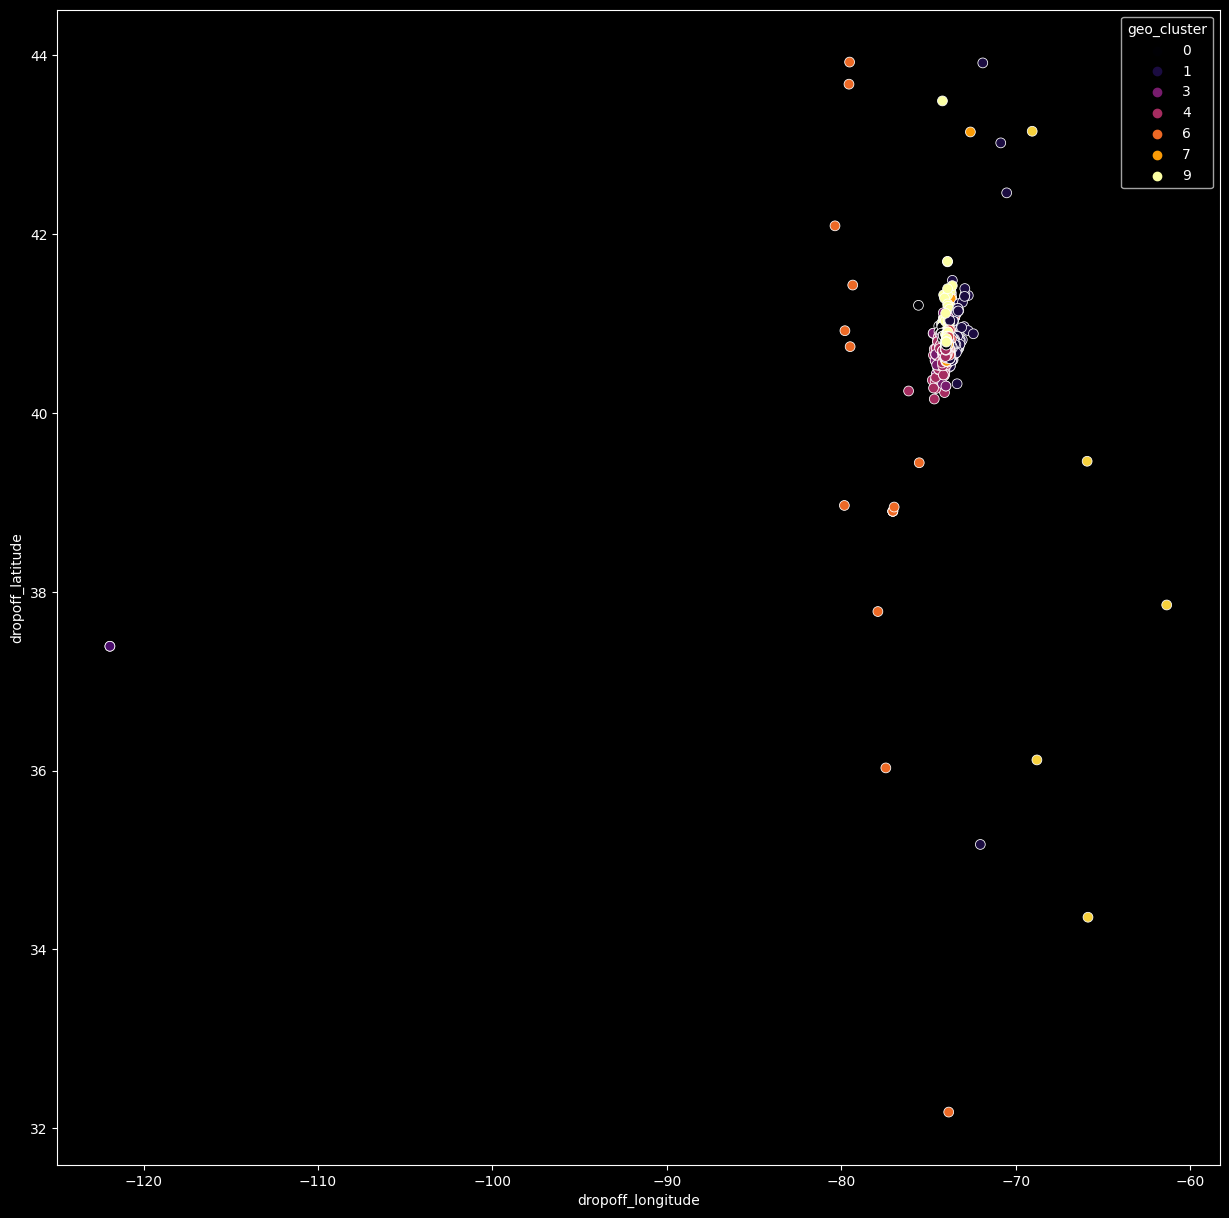

In [43]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot2 = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='inferno',
    s=50
);
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot2.set_title('Географическое расположение точек окончания поездок', fontsize=16);
scatterplot2.set_xlabel('Широта');
scatterplot2.set_ylabel('Долгота');

✍ Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.

Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать.

Надо отобрать признаки, которые мы будем использовать для обучения модели.
Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

Для начала давайте сверим размерность.

Проверьте, что ваши признаки совпадают с нашими:

In [44]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458237, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [46]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Ранее мы извлекли всю необходимую информацию из даты начала поездки. Теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:

In [47]:
drop_columns = ['pickup_datetime', 'pickup_date','id','dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458237, 23)


Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

vendor_id;
store_and_fwd_flag;
pickup_day_of_week;
geo_cluster;
events.
Первые два (vendor_id и store_and_fwd_flag) из них являются бинарными (имеют два уникальных значения). Давайте их закодируем

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.
Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.
1. Рассчитайте среднее по закодированному столбцу vendor_id. Ответ округлите до второго знака после точки-разделителя.

In [48]:
train_data['vendor_id'] = train_data['vendor_id'].astype(str)
train_data["vendor_id"] = np.where(train_data["vendor_id"].str.contains('1'), 0, 1)
print(f'Среднее по закодированному столбцу vendor_id: {round(train_data["vendor_id"].mean(),2)}')

Среднее по закодированному столбцу vendor_id: 0.53


2. Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ округлите до третьего знака после точки-разделителя.

In [49]:
train_data["store_and_fwd_flag"] = np.where(train_data["store_and_fwd_flag"].str.contains('N'), 0, 1)
print(f'Среднее по закодированному столбцу store_and_fwd_flag: {round(train_data["store_and_fwd_flag"].mean(),3)}')

Среднее по закодированному столбцу store_and_fwd_flag: 0.006


Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder() из библиотеки sklearn. В качестве значения параметра drop возьмите 'first', чтобы удалять первый бинарный столбец и тем самым не создавать излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате ‹оригинальное имя столбца›_‹имя категории›.

Пример использования:

In [50]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 18 бинарных столбцов


Добавим полученную таблицу с закодированными признаками:

In [51]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Получилась таблица с размерами: {}'.format(train_data.shape))

Получилась таблица с размерами: (1458237, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:

In [52]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458237 entries, 0 to 1458236
Data columns (total 36 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   vendor_id                     1458237 non-null  int32  
 1   passenger_count               1458237 non-null  int64  
 2   pickup_longitude              1458237 non-null  float64
 3   pickup_latitude               1458237 non-null  float64
 4   dropoff_longitude             1458237 non-null  float64
 5   dropoff_latitude              1458237 non-null  float64
 6   store_and_fwd_flag            1458237 non-null  int32  
 7   pickup_hour                   1458237 non-null  int64  
 8   pickup_holiday                1458237 non-null  object 
 9   total_distance                1458237 non-null  float64
 10  total_travel_time             1458237 non-null  float64
 11  number_of_steps               1458237 non-null  float64
 12  haversine_distance          

Все наши модели мы будем обучать на логарифмированной версии y_log.

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать hold-out-валидацию. Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и времязатратным.

Разобьём выборку на обучающую и валидационную в соотношении 67/33:

In [54]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

Примечание. Тестовая выборка, с которой мы познакомимся позднее, представлена отдельным датасетом. Истинные длительности поездок из тестового набора являются для нас неизвестными. Финальное качество модели можно было бы узнать, только сделав предсказание и отправив файл с предсказанием на проверку на платформе Kaggle.

На данный момент у нас достаточно много признаков — скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели ↓

Задание 4.4
1 point possible (graded)
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

В тренировочной и валидационной выборке оставьте только полученные 25 признаков, откинув ненужные. Далее мы будем работать и строить модели на отобранных признаках.

Укажите признаки, которые вошли в список отобранных:

In [55]:
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977018 entries, 1144842 to 121958
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977018 non-null  int32  
 1   passenger_count               977018 non-null  int64  
 2   pickup_longitude              977018 non-null  float64
 3   pickup_latitude               977018 non-null  float64
 4   dropoff_longitude             977018 non-null  float64
 5   dropoff_latitude              977018 non-null  float64
 6   store_and_fwd_flag            977018 non-null  int32  
 7   pickup_hour                   977018 non-null  int64  
 8   pickup_holiday                977018 non-null  object 
 9   total_distance                977018 non-null  float64
 10  total_travel_time             977018 non-null  float64
 11  number_of_steps               977018 non-null  float64
 12  haversine_distance            977018 n

In [56]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481219 entries, 1251244 to 293850
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     481219 non-null  int32  
 1   passenger_count               481219 non-null  int64  
 2   pickup_longitude              481219 non-null  float64
 3   pickup_latitude               481219 non-null  float64
 4   dropoff_longitude             481219 non-null  float64
 5   dropoff_latitude              481219 non-null  float64
 6   store_and_fwd_flag            481219 non-null  int32  
 7   pickup_hour                   481219 non-null  int64  
 8   pickup_holiday                481219 non-null  object 
 9   total_distance                481219 non-null  float64
 10  total_travel_time             481219 non-null  float64
 11  number_of_steps               481219 non-null  float64
 12  haversine_distance            481219 n

Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

In [57]:
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_valid_scaled = scaler.transform(X_valid)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [58]:
print(f'Cреднее арифметическое из валидационной выборки: {round(X_valid.mean(), 2)}')
print(f'Cреднее арифметическое для первого предиктора из валидационной выборки: {X_valid[:,0].mean().round(2)}')

Cреднее арифметическое из валидационной выборки: 0.25
Cреднее арифметическое для первого предиктора из валидационной выборки: 0.53


Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе).

Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [60]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)
y_train_log_pred = lr.predict(X_train)
y_valid_log_pred = lr.predict(X_valid)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.54
RMSLE метрика в Valid выборке: 0.54


Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.¶

In [61]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train_log)
y_train_log_pred = dt.predict(X_train)
y_valid_log_pred = dt.predict(X_valid)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке: 0.00
метрика RMSLE на валидационной выборке: 0.57


Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

In [62]:
param_grid = {'max_depth': range(7, 20)}
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs = -1
)
grid_search.fit(X_train, y_train_log)
print("Оптимальная глубина дерева решений: {}".format(grid_search.best_params_))

Оптимальная глубина дерева решений: {'max_depth': 11}


б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной?

Ответ округлите до сотых.

In [63]:
dtr = tree.DecisionTreeRegressor(max_depth=12)
dtr.fit(X_train, y_train_log)
y_train_log_pred = dtr.predict(X_train)
y_valid_log_pred = dtr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для дерева решений с выбранной оптимальной глубиной: 0.41
метрика RMSLE на валидационной выборке для дерева решений с выбранной оптимальной глубиной: 0.43


Задание 6.1.
Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:

n_estimators=200,
max_depth=12,
criterion='squared_error',
min_samples_split=20,
random_state=42
Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [64]:
rfr = RandomForestRegressor(n_estimators = 200,
                            max_depth = 12,
                            criterion = 'squared_error',
                            min_samples_split = 20,
                            random_state = 42)
rfr.fit(X_train, y_train_log)
y_train_log_pred = rfr.predict(X_train)
y_valid_log_pred = rfr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели случайного леса: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели случайного леса: 0.40
метрика RMSLE на валидационной выборке для модели случайного леса: 0.41


Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:

learning_rate=0.5,
n_estimators=100,
max_depth=6,
min_samples_split=30,
random_state=42
Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [65]:
gbr = GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=100,
                                max_depth=6,
                                min_samples_split=30,
                                random_state=42)
gbr.fit(X_train, y_train_log)
y_train_log_pred = gbr.predict(X_train)
y_valid_log_pred = gbr.predict(X_valid)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 0.37
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 0.39


Задание 6.4.¶
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

In [66]:
coef = gbr.feature_importances_
data = pd.DataFrame([coef], columns=best_features)
data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_3,geo_cluster_5,geo_cluster_7,geo_cluster_9
0,0.005621,0.000711,0.01441,0.010466,0.012742,0.029057,0.000027,0.058523,0.001286,0.630322,...,0.005482,0.00752,0.000424,0.000693,0.000658,0.0001,0.000031,0.000147,0.000242,0.000851


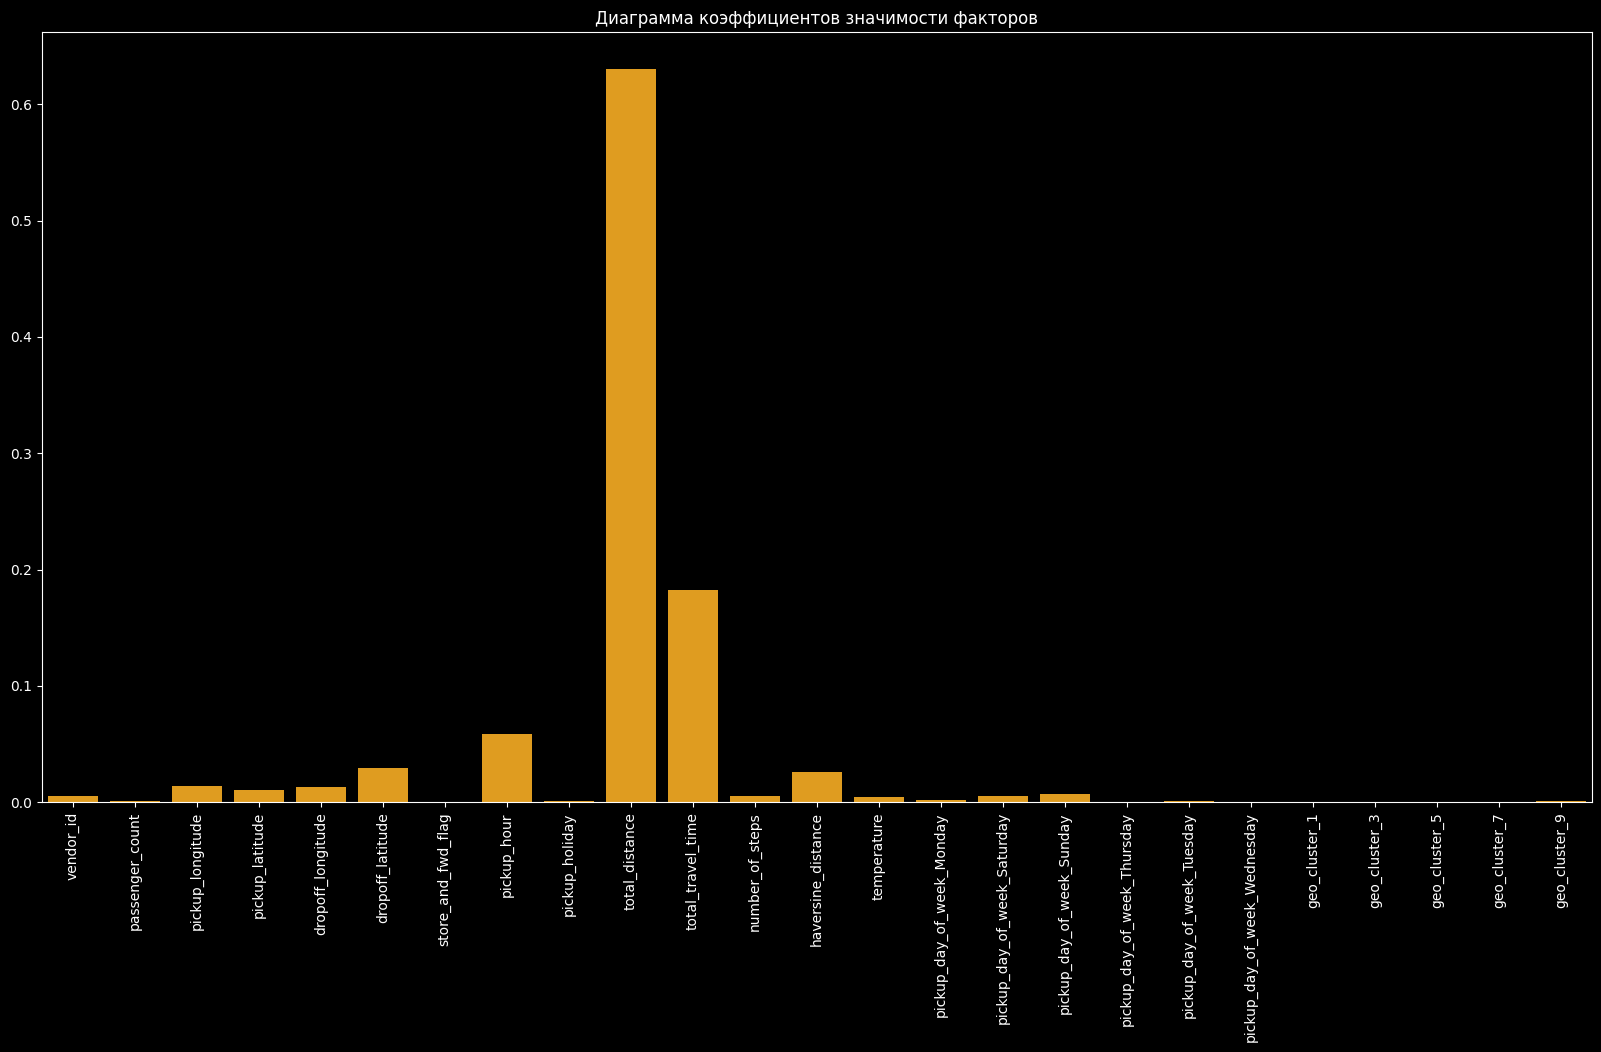

In [67]:
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=data,color="orange")
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 90);

Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
MeAE = median(|yi−^yi|)

Значение метрики MeAE переведите в минуты и округлите до десятых.

In [68]:
y_norm = np.exp(y_valid_log)-1
y_norm_pred = np.exp(y_valid_log_pred)-1
from sklearn.metrics import median_absolute_error
MeAE = metrics.median_absolute_error(y_norm, y_norm_pred)/60
print(f'медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: {round(MeAE, 1)}')

медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: 1.8


Финальный шаг - сделать submit - предсказание для отложенного тестового набора данных.
Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:

In [69]:
test_data = pd.read_csv("content/Project5_test_data.csv")
osrm_data_test = pd.read_csv("content/Project5_osrm_data_test.csv")
test_id = test_data['id']

In [70]:
test_data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:

Перевести признак pickup_datetime в формат datetime;

In [71]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

Добавить новые признаки (временные, географические, погодные и другие факторы);

In [72]:
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17944\3201036679.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["pickup_holiday"].loc[merged_df["pickup_holiday"] != 0] = 1


Произвести очистку данных от пропусков;

In [73]:
test_data = fill_null_weather_data (test_data)

Произвести кодировку категориальных признаков:
Закодировать бинарные признаки;
Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;

In [74]:
one_hot_encoder = OneHotEncoder(drop='first')
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;

In [75]:
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)

In [76]:
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
yi = exp(zi)−1

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

In [77]:
y_test_log_pred = gbr.predict(X_test_scaled)
y_test_predict = np.exp(y_test_log_pred)-1

In [78]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

In [79]:
from IPython.display import FileLink
FileLink('submission.csv')

c:\Users\Lenovo\Desktop\Новая папка\submission.csv